In [1]:
#### Require python 3.10+
!python --version

Python 3.10.12


In [2]:
conda install -c conda-forge ipywidgets

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.11.1
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.4



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [146]:
!pip install --no-cache-dir opensearch-py python-dotenv boto3 tqdm h5py matplotlib ipywidgets jedi ipython matplotlib 


In [ ]:
# For autocomplete use shift+tab
%config IPCompleter.greedy=True

In [ ]:
# Download the sift-128 dataset
!curl -o sift-128-euclidean.hdf5 -L http://ann-benchmarks.com/sift-128-euclidean.hdf5

In [9]:
# Read Data set
import numpy as np
import h5py

dataset = h5py.File('sift-128-euclidean.hdf5', "r")
X_TRAIN = np.array(dataset["train"])
X_TEST = np.array(dataset["test"])
dimension = int(dataset.attrs["dimension"]) if "dimension" in dataset.attrs else len(X_TRAIN[0])

print(f"Ingest dataset size is : {len(X_TRAIN)}")
print(f"Queries dataset size is : {len(X_TEST)}")
print(f"dataset dimensions is : {dimension}")

Ingest dataset size is : 1000000
Queries dataset size is : 10000
dataset dimensions is : 128


In [10]:
from dotenv import load_dotenv
from opensearchpy import OpenSearch, RequestsHttpConnection
import os


res = load_dotenv("environment.txt")

OS_HOST = os.getenv('OS_HOST')
OS_PORT = os.getenv('OS_PORT')
OS_USER = os.getenv('USER_NAME')
OS_PASSWORD = os.getenv('PASSWORD')
vector_index_name = os.getenv('VECTOR_INDEX_NAME', "test-vector")


client = OpenSearch(
    hosts = [{'host': OS_HOST, 'port': OS_PORT}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (OS_USER, OS_PASSWORD),
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    timeout=6000,
    pool_maxsize = 20
)

client.info()

print(f"vector index name from env is : {vector_index_name}")

{'name': '428d6ce63b054e8d1dd55d36eb0ea810',
 'cluster_name': '199552501713:go-daddy-xlarge',
 'cluster_uuid': 'Sc_tsdMeQ-6R8gdYNCY1FQ',
 'version': {'distribution': 'opensearch',
  'number': '2.7.0',
  'build_type': 'tar',
  'build_hash': 'unknown',
  'build_date': '2023-08-08T16:51:18.396423063Z',
  'build_snapshot': False,
  'lucene_version': '9.5.0',
  'minimum_wire_compatibility_version': '7.10.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'The OpenSearch Project: https://opensearch.org/'}

In [57]:
def create_index(index_name):
    index_mappings = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0,
            "index": {
            "knn": True,
            "knn.algo_param.ef_search": 128, # Adjust to improve precision. Higher improves recall & precsion but increases latency. Lower degrades recall & precision but improves latency.
            "refresh_interval" : "-1" # This is to ensure that we are creating mininal number of segments.
            }
        },
        "mappings": {
            "properties": {
                "vec": {
                    "type": "knn_vector",
                    "dimension": dimension,
                    "index": "true",
                    "method": {
                        "name": "hnsw",
                        "space_type": "l2", # l2 for SIFT, cosinesimil for typical
                        "engine": "nmslib",
                        "parameters": {
                            "ef_construction": 128
                        }
                    }
                }
            }
        }
    }

    if client.indices.exists(index=index_name):
        response = client.indices.delete(index=index_name)
        print(f"Deleting the index. Response : {response}")

    response = client.indices.create(index=index_name, body=index_mappings)
    print(f"Creating the index. Response : {response}")



vector name from env is : test_vector
Deleting the index. Response : {'acknowledged': True}
Creating the index. Response : {'acknowledged': True, 'shards_acknowledged': True, 'index': 'test_vector'}


In [58]:
# ingest data in the index
from tqdm.notebook import tqdm
from opensearchpy.helpers import bulk
import time


create_index(vector_index_name)

bulk_size = 1000
def dataGen():
    for i, vec in enumerate(X_TRAIN):
        yield { "_index": vector_index_name, "_id": str(i + 1), "vec": vec.tolist() }

data_to_ingest = []
total_time_to_ingest = 0.
ingest_latency = []
for data in tqdm(dataGen(), total=len(X_TRAIN)):
    if len(data_to_ingest) == bulk_size:
        start = time.time()
        (res, errors) = bulk(client, data_to_ingest)
        end = time.time()
        total_time_to_ingest += (end-start)
        ingest_latency.append(end-start)
        if len(errors) != 0:
            print(errors)
            data_to_ingest = []
            StopIteration
        else:
            data_to_ingest = []

    if len(data_to_ingest) < bulk_size:
        data_to_ingest.append(data)
    

if len(data_to_ingest) != 0:
    start = time.time()
    (_, errors) = bulk(client, data_to_ingest)
    end = time.time()
    total_time_to_ingest += (end-start)
    if len(errors) != 0:
        print(errors)
    else:
        data_to_ingest = []

print(f"Ingestion completed. Total time to ingest = {total_time_to_ingest} seconds, average time per document: {total_time_to_ingest/(len(X_TRAIN))}")


  0%|          | 0/1000000 [00:00<?, ?it/s]

Ingestion completed. Total time to ingest = 1092.6282296180725 seconds, average time per document: 0.0010926282296180726


In [62]:
# Refresh the index as we set the refresh interval to -1
client.indices.refresh(index=vector_index_name)



{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

In [179]:
# Check index details, you should see 1M documents in the index.
print(client.cat.indices(index=vector_index_name))

print("Segments Info After refresh...")

segments = client.cat.segments(vector_index_name, params={"format": "json"})

print(f"Total segments are: {len(segments)}")

print(f"Printing Segment info : \n{client.cat.segments(index=vector_index_name, params={'format': 'csv', 'v': 'true'})}")


green open test_vector s4owFlx_Tv2pX41NDYpu-w 1 0 1000000 0 1.4gb 1.4gb

Segments Info After refresh...
Total segments are: 7, [{'index': 'test_vector', 'shard': '0', 'prirep': 'p', 'ip': 'x.x.x.x', 'segment': '_0', 'generation': '0', 'docs.count': '760827', 'docs.deleted': '0', 'size': '1gb', 'size.memory': '0', 'committed': 'true', 'searchable': 'true', 'version': '9.5.0', 'compound': 'true'}, {'index': 'test_vector', 'shard': '0', 'prirep': 'p', 'ip': 'x.x.x.x', 'segment': '_1', 'generation': '1', 'docs.count': '63800', 'docs.deleted': '0', 'size': '93.6mb', 'size.memory': '0', 'committed': 'true', 'searchable': 'true', 'version': '9.5.0', 'compound': 'true'}, {'index': 'test_vector', 'shard': '0', 'prirep': 'p', 'ip': 'x.x.x.x', 'segment': '_2', 'generation': '2', 'docs.count': '4298', 'docs.deleted': '0', 'size': '6.3mb', 'size.memory': '0', 'committed': 'true', 'searchable': 'true', 'version': '9.5.0', 'compound': 'true'}, {'index': 'test_vector', 'shard': '0', 'prirep': 'p', 'ip

In [82]:
# Uncomment the below code to optimize the search latency
# Run few queries to load the data in cache. We are running 10 queries here to warmup the cluster
# Read more ways to tune the cluster here: https://opensearch.org/docs/latest/search-plugins/knn/performance-tuning/

# X_WARMUP = X_TEST[0:10]
# for query in tqdm(searchQueryGen(X_WARMUP), total=len(X_WARMUP)):
#     search_response = client.search(body=query, index=vector_index_name, _source=False, docvalue_fields=["_id"], stored_fields="_none_")

# print("--- Warmuped up the Cluster----")



  0%|          | 0/10 [00:00<?, ?it/s]

--- Warmup up the Cluster----


In [149]:
# Setup for Search
import numpy as np
from tqdm.notebook import tqdm

# search in the index
def searchQueryGen(input_array=X_TEST):
    for i, vec in enumerate(input_array):
        yield {
            "_source": False, # Don't get the source as this impacts latency
            "size": 100,
            "query": {
                "knn": {
                    "vec": {
                        "vector": vec.tolist(),
                        "k": 100
                    }
                }
            }
        }


neighbors_lists = []
search_latency = []
took_time = []
for query in tqdm(searchQueryGen(), total=len(X_TEST)):
    start = time.time()
    search_response = client.search(body=query, index=vector_index_name, _source=False, docvalue_fields=["_id"], stored_fields="_none_")
    end = time.time()
    search_latency.append(end - start)
    took_time.append(search_response["took"])
    search_hits = search_response['hits']['hits']
    search_neighbors = [int(hit["fields"]["_id"][0]) for hit in search_hits]
    neighbors_lists.append(search_neighbors)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [150]:
# Useful Metrics
print("========================== Search Metrics ===================================")
print("========================== Server Side Latency ===================================")
print(f"average took_time(ms): {np.average(took_time)}") 
print(f"p50 took_time(ms): {np.percentile(took_time, 50)}") 
print(f"p90 took_time(ms): {np.percentile(took_time, 90)}")
print(f"p90 took_time(ms): {np.percentile(took_time, 99)}")


print("========================== Client side latency ===================================")
print(f"\n\naverage Latency(ms): {np.average(search_latency) *1000}") 
print(f"p50 Latency(ms): {np.percentile(search_latency, 50) *1000}") 
print(f"p90 Latency(ms): {np.percentile(search_latency, 90) *1000}")
print(f"p99 Latency(ms): {np.percentile(search_latency, 99) *1000}")




========================== Search Metrics ===================================
========================== Server Side Latency ===================================
average took_time(ms): 3.191
p50 took_time(ms): 3.0
p90 took_time(ms): 4.0
p90 took_time(ms): 4.0
========================== Client side latency ===================================


average Latency(ms): 137.8559402704239
p50 Latency(ms): 109.4275712966919
p90 Latency(ms): 188.31233978271487
p99 Latency(ms): 472.7909421920804


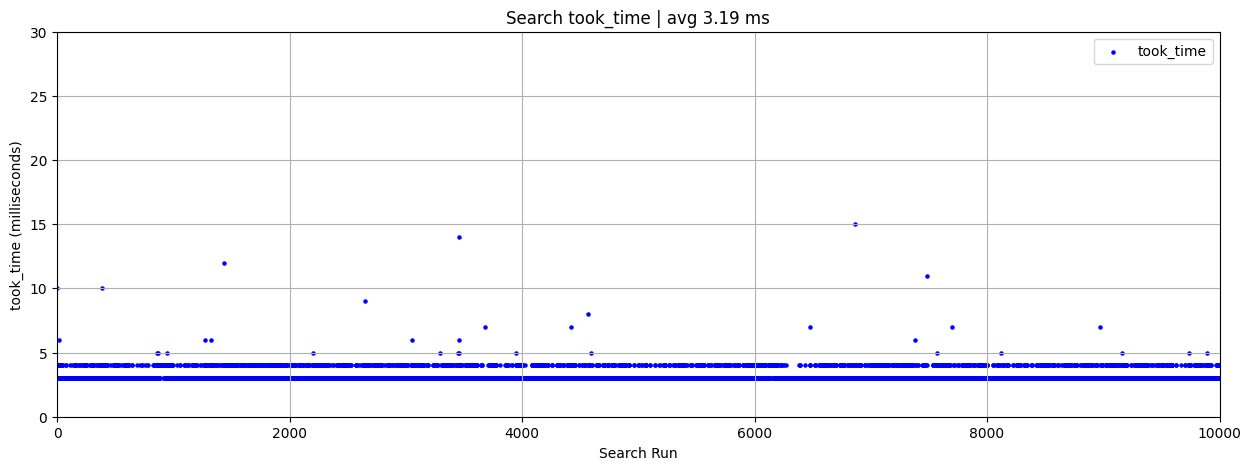

In [151]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "took_time": took_time
})

avg_latency = sum(took_time) / len(took_time)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['took_time'], label="took_time", color='blue', s=5)
plt.title(f"Search took_time | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(X_TEST)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 30) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("took_time (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

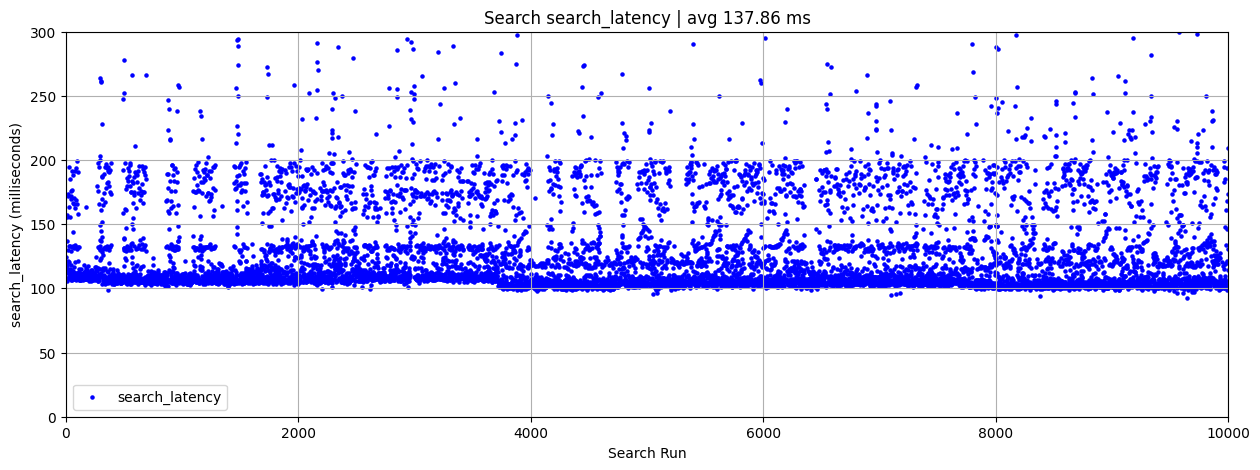

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "search_latency": [(lat*1000) for lat in search_latency]
})

avg_latency = sum([(lat*1000) for lat in search_latency]) / len(search_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['search_latency'], label="search_latency", color='blue', s=5)
plt.title(f"Search search_latency | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, len(X_TEST)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 300) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("search_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Parallelization for Ingest
import multiprocessing.pool
from tqdm.notebook import tqdm
import time
from opensearchpy.helpers import bulk

def ingest_data(client_number, vectors_to_be_ingested, start_id):
    print(f"Starting ingest for client {client_number} for vectors counts: {len(vectors_to_be_ingested)}")
    def dataGenLocal():
        for i, vec in enumerate(vectors_to_be_ingested):
            yield { "_index": vector_index_name, "_id": str(start_id + i + 1), "vec": vec.tolist() }

    bulk_size = 1000
    data_to_ingest = []
    total_time_to_ingest = 0.
    ingest_latency = []
    for data in tqdm(dataGenLocal(), total=len(vectors_to_be_ingested)):
        if len(data_to_ingest) == bulk_size:
            start = time.time()
            (res, errors) = bulk(client, data_to_ingest)
            end = time.time()
            total_time_to_ingest += (end-start)
            ingest_latency.append(end-start)
            if len(errors) != 0:
                print(errors)
                data_to_ingest = []

                StopIteration
            else:
                data_to_ingest = []

        if len(data_to_ingest) < bulk_size:
            data_to_ingest.append(data)
        

    if len(data_to_ingest) != 0:
        start = time.time()
        (res, errors) = bulk(client, data_to_ingest)
        end = time.time()
        total_time_to_ingest += (end-start)
        if len(errors) != 0:
            print(errors)
        else:
            data_to_ingest = []
    return total_time_to_ingest, ingest_latency, errors
    
    

create_index(vector_index_name)

clients = 10 # change this to whatever value is suited for you

vectors_per_client = len(X_TRAIN)//clients

print(f"Total Vectors are: {len(X_TEST)}, vectors per client is : {vectors_per_client}")


vectors = []
batch = []
i = 0
print(f"Partioning the data...")
for vector in X_TRAIN:
    i = i + 1
    if len(batch) == vectors_per_client:
        vectors.append(batch)
        batch = []
    batch.append(vector)
# Put the last batch of vectors
vectors.append(batch)

mp_total_time_to_ingest = 0.
mp_ingest_latency = []
mp_errors = []
ctx = multiprocessing.get_context("fork")
with ctx.Pool(clients) as pool:
    ingest_arg_tuple = [(idx + 1, vectors[idx], idx * vectors_per_client) for idx in range(clients)]
    ingestion_response = list(pool.starmap(ingest_data, ingest_arg_tuple))
for future in ingestion_response:
    t_time_to_ingest, i_latency, errors = future
    mp_total_time_to_ingest += t_time_to_ingest
    mp_ingest_latency.extend(i_latency)
    mp_errors.extend(errors)

if len(mp_errors) !=0 :
    print(f"Errors happened while doing the ingest. {errors}")
else:
    print(f"Total time to ingest documents are : {mp_total_time_to_ingest} for documents : {len(X_TEST)}")



In [ ]:
# Useful Metrics For Multi Processing Ingestion
print("========================== Ingest Metrics Multi Processing ===================================")

print("========================== Client side latency ===================================")
print(f"\n\naverage Latency(ms): {np.average(mp_ingest_latency) *1000} for bulksize: {bulk_size}") 
print(f"p50 Latency(ms): {np.percentile(mp_ingest_latency, 50) *1000} for bulksize: {bulk_size}") 
print(f"p90 Latency(ms): {np.percentile(mp_ingest_latency, 90) *1000} for bulksize: {bulk_size}")
print(f"p99 Latency(ms): {np.percentile(mp_ingest_latency, 99) *1000} for bulksize: {bulk_size}") 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "mp_ingest_latency": [(lat*1000) for lat in mp_ingest_latency]
})

avg_latency = sum([(lat*1000) for lat in mp_ingest_latency]) / len(mp_ingest_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['mp_ingest_latency'], label="mp_ingest_latency", color='blue', s=5)
plt.title(f"Ingest mp_ingest_latency | avg {avg_latency:.2f} ms for bulk size : {bulk_size}")
plt.xlabel("Ingest Run")
plt.xlim(0, len(X_TRAIN)) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 1000) 
plt.ylabel("mp_ingest_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

In [27]:
# Parallelization for Search
import multiprocessing.pool
from tqdm.notebook import tqdm
import time

def run_search(client_number, query_list):
    neighbors_lists = []
    search_latency = []
    took_time = []
    print(f"client_number : {client_number}, query: {len(query_list)}")
    # Better to create client for each process so that no locking happens
    c = OpenSearch(
        hosts = [{'host': OS_HOST, 'port': OS_PORT}],
        http_compress = True, # enables gzip compression for request bodies
        http_auth = (OS_USER, OS_PASSWORD),
        use_ssl = True,
        verify_certs = True,
        connection_class = RequestsHttpConnection,
        timeout=6000,
        pool_maxsize = 20
    )
    # Doing an info call to make sure client is ready, this will avoid the latency for 1st connection
    c.info()
    
    for query in tqdm(query_list):
        query_body = {
            "size": 100,
            "query": {
                "knn": {
                    "vec": {
                        "vector": query.tolist(),
                        "k": 100
                    }
                }
            }
        }
        start = time.time()
        search_response = c.search(body=query_body, index=vector_index_name, _source=False, docvalue_fields=["_id"], stored_fields="_none_")
        end = time.time()
        search_latency.append(end - start)
        took_time.append(search_response["took"])
        search_hits = search_response['hits']['hits']
        search_neighbors = [int(hit["fields"]["_id"][0]) for hit in search_hits]
        neighbors_lists.append(search_neighbors)
    return search_latency, took_time, neighbors_lists
        

clients = 10

queries_per_client = len(X_TEST)//clients

print(f"Total Queries are: {len(X_TEST)}, queries per client is : {queries_per_client}")


queries = []
batch = []
i = 0
for query in X_TEST:
    i = i + 1
    if len(batch) == queries_per_client:
        queries.append(batch)
        batch = []
    batch.append(query)
# Put the last batch of queries
queries.append(batch)

mp_neighbors_lists = []
mp_search_latency = []
mp_took_time = []

ctx = multiprocessing.get_context("fork")
with ctx.Pool(clients) as pool:
    query_arg_tuple = [(idx + 1, queries[idx]) for idx in range(clients)]
    queries_response = list(pool.starmap(run_search, query_arg_tuple))
for future in queries_response:
    s_lat, t_time, n_lists = future
    mp_search_latency.extend(s_lat)
    mp_neighbors_lists.extend(n_lists)
    mp_took_time.extend(t_time)




Total Queries are: 10000, queries per client is : 1000
client_number : 1, query: 1000client_number : 2, query: 1000

client_number : 3, query: 1000
client_number : 4, query: 1000
client_number : 5, query: 1000
client_number : 6, query: 1000
client_number : 7, query: 1000
client_number : 8, query: 1000
client_number : 10, query: 1000client_number : 9, query: 1000



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
# Useful Metrics For Multi Processing
print("========================== Search Metrics Multi Processing ===================================")
print("========================== Server Side Latency ===================================")
print(f"average took_time(ms): {np.average(mp_took_time)}") 
print(f"p50 took_time(ms): {np.percentile(mp_took_time, 50)}") 
print(f"p90 took_time(ms): {np.percentile(mp_took_time, 90)}")
print(f"p90 took_time(ms): {np.percentile(mp_took_time, 99)}")


print("========================== Client side latency ===================================")
print(f"\n\naverage Latency(ms): {np.average(mp_search_latency) *1000}") 
print(f"p50 Latency(ms): {np.percentile(mp_search_latency, 50) *1000}") 
print(f"p90 Latency(ms): {np.percentile(mp_search_latency, 90) *1000}")
print(f"p99 Latency(ms): {np.percentile(mp_search_latency, 99) *1000}")
   


========================== Search Metrics Multi Processing ===================================
========================== Server Side Latency ===================================
average took_time(ms): 6.1174
p50 took_time(ms): 5.0
p90 took_time(ms): 11.0
p90 took_time(ms): 19.0
========================== Client side latency ===================================


average Latency(ms): 33.718440842628475
p50 Latency(ms): 32.930731773376465
p90 Latency(ms): 44.56498622894287
p99 Latency(ms): 57.07549810409547


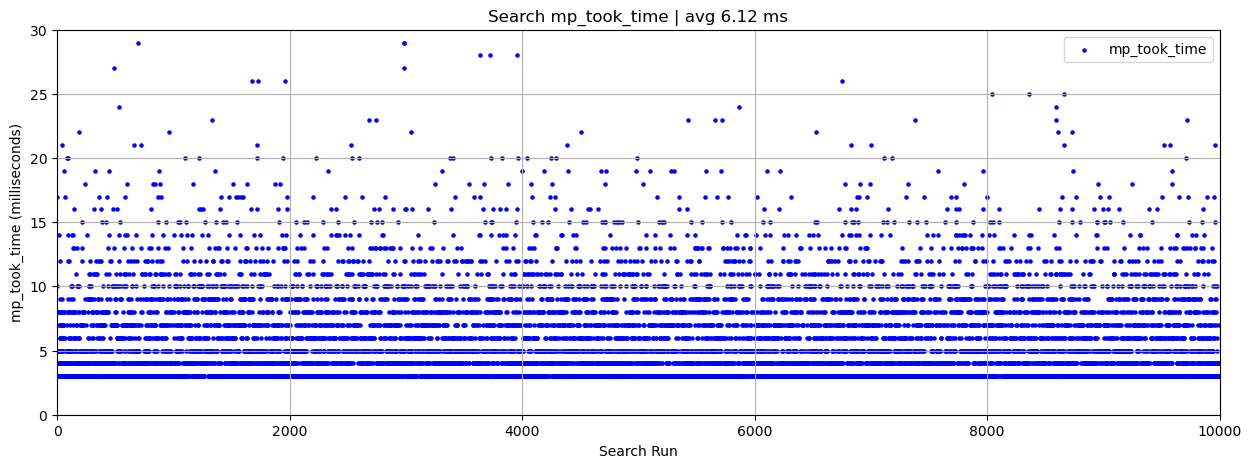

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "mp_took_time": mp_took_time
})

avg_latency = sum(mp_took_time) / len(mp_took_time)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['mp_took_time'], label="mp_took_time", color='blue', s=5)
plt.title(f"Search mp_took_time | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, 10000) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 30) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("mp_took_time (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()

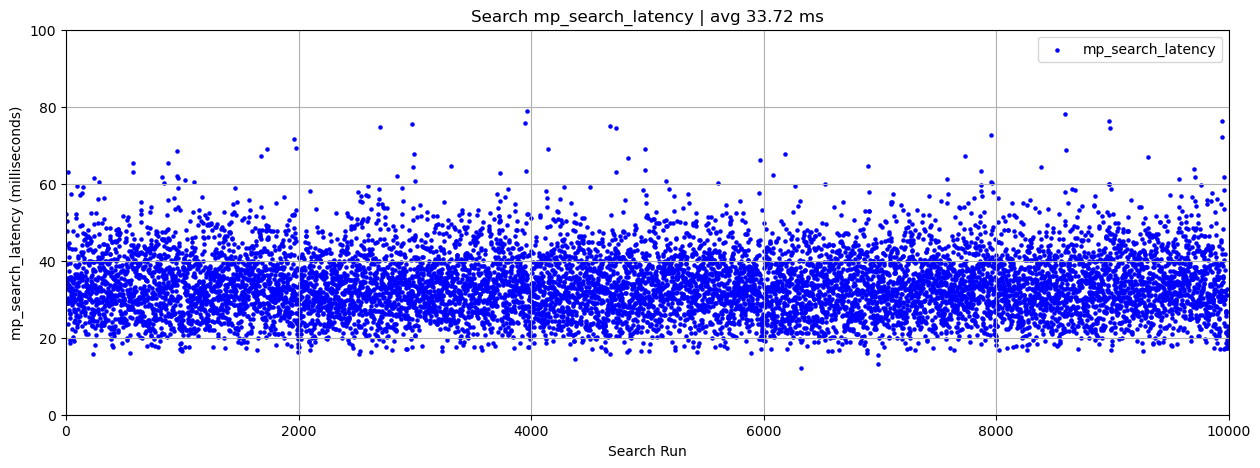

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "mp_search_latency": [(lat*1000) for lat in mp_search_latency]
})

avg_latency = sum([(lat*1000) for lat in mp_search_latency]) / len(mp_search_latency)

plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['mp_search_latency'], label="mp_search_latency", color='blue', s=5)
plt.title(f"Search mp_search_latency | avg {avg_latency:.2f} ms")
plt.xlabel("Search Run")
plt.xlim(0, 10000) # change this value to view a wider range of data. (Search Run Batch)
plt.ylim(0, 100) # change this value to view the precision/recall, some values may be out of view.
plt.ylabel("mp_search_latency (milliseconds)")
plt.legend()
plt.grid(True)

plt.show()